In [ ]:
#classification.py
import datetime
import pickle
import csv
import random
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, \
    mean_squared_error, classification_report, accuracy_score
from sklearn.svm import SVC


sampling_rate=128
def __reshape_for_nn(data_list):
    rehshaped_list = []
    for item in data_list:
        a, b = item.shape
        reshaped_array = item.reshape(a, b, 1)
        rehshaped_list.append(reshaped_array)
    return np.array(rehshaped_list)

def __reshape(data_list):
    rehshaped_list = []
    for item in data_list:
        a, b = item.shape
        reshaped_array = item.reshape(a * b)
        rehshaped_list.append(reshaped_array)
    return np.array(rehshaped_list)

def feature_scaling(data):
    scaler = StandardScaler()
    #train_x = scaler.fit_transform(segmented_train_list)
    #test_x = scaler.fit_transform(segmented_test_list)

    data_array = np.array(data)
    print(data_array.shape)
    trials, channels, samples = data_array.shape
    #mean_array = data_array.mean(axis=(0))
    #std_array = data_array.std(axis=(0))
    i = 0
    while i < trials:
        #display_eeg_signal(data_array[i, :, :], horizental_order)
        #data_array[i, :, :] = (data_array[i, :, :] - mean_array) / std_array
        data_array[i, :, :] = scaler.fit_transform(data_array[i, :, :])
        #display_eeg_signal(data_array[i, :, :], horizental_order)
        i += 1
    print(data_array.shape)
    return data_array

def total_power_bands_svm(train_x, train_y, test_x, test_y):
    '''
    Calculates power bands for each trial, flatten all channels,
    uses SVM for classification
    '''
    model = SVC(kernel='linear', probability=True, tol=1e-3, degree=2)
    model.fit(train_x, np.array(train_y))
    accuracy = model.score(test_x, np.array(test_y))
    preds_y = model.predict(test_x)
    print("preds", preds_y)
    print("real", test_y)
    print(confusion_matrix(test_y, preds_y))
    precision, recall, f_score, support = \
        precision_recall_fscore_support(np.array(test_y), preds_y, average='macro')
    print("precision={}, recall={}, f_score={}, support={}".format(precision,
                                                                   recall,
                                                                   f_score,
                                                                   support))
    print("Classification report", classification_report(test_y, preds_y))

    rmse = sqrt(mean_squared_error(test_y, preds_y))
    print("accuracy = ", accuracy)
    print("RMSE = ", rmse)
    return accuracy, precision, recall, f_score, rmse

def segmented_total_power_bands(train_x, train_y, test_x, test_y, part_length):
    '''
    '''
    segmented_train_list, segmented_train_labels = \
        segmentation1(train_x, train_y, part_length * sampling_rate)
    segmented_test_list, segmented_test_labels = \
        segmentation1(test_x, test_y, part_length * sampling_rate)
    #joint = list(zip(segmented_train_list, segmented_train_labels))
    #random.shuffle(joint)
    #segmented_train_list, segmented_train_labels = zip(*joint)
    return total_power_bands_svm(segmented_train_list,
                                 segmented_train_labels,
                                 segmented_test_list, segmented_test_labels)

def segmented_total_power_bands_lstm(train_x, train_y, test_x, test_y):
    checkpoint = \
        ModelCheckpoint("models/segmented_total_power_bands_lstm.h5",
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        period=1)
    early_stopping = \
        EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=100,
                      verbose=1,
                      mode='auto')
    model = simple_eeg_binary_lstm((train_x.shape[1], train_x.shape[2]), 100)

    model.fit(np.array(train_x),
              np.array(train_y),
              epochs=1000,
              batch_size=64,
              validation_data=(np.array(test_x),
                               np.array(test_y)),
              callbacks=[checkpoint, early_stopping])
    return validate_lstm_model(load_model("models/segmented_total_power_bands_lstm.h5"),
                               np.array(test_x),
                               np.array(test_y))

def segmented_total_power_bands_lstm_categorcal(train_x, train_y, test_x, test_y):
    checkpoint = \
        ModelCheckpoint("models/segmented_total_power_bands_lstm.h5",
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        period=1)
    early_stopping = \
        EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=100,
                      verbose=1,
                      mode='auto')
    model = simple_eeg_lstm((train_x.shape[1], train_x.shape[2]), 100, 2)

    model.fit(np.array(train_x),
              np.array(train_y),
              epochs=1000,
              batch_size=64,
              validation_data=(np.array(test_x),
                               np.array(test_y)),
              callbacks=[checkpoint, early_stopping])

    return validate_model_categorical(load_model("models/segmented_total_power_bands_lstm.h5"),
                                      np.array(test_x),
                                      np.array(test_y))
def segmented_psd_lstm_categorcal(train_x, train_y, test_x, test_y):
    print("final_shape", train_x.shape)
    checkpoint = \
        ModelCheckpoint("models/segmented_psd_lstm.h5",
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        period=1)
    early_stopping = \
        EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=100,
                      verbose=1,
                      mode='auto')
    model = simple_eeg_lstm((train_x.shape[1], train_x.shape[2]), 100, 2)

    model.fit(np.array(train_x),
              np.array(train_y),
              epochs=1000,
              batch_size=64,
              validation_data=(np.array(test_x),
                               np.array(test_y)),
              callbacks=[checkpoint, early_stopping])

    return validate_model_categorical(load_model("models/segmented_psd_lstm.h5"),
                                      np.array(test_x),
                                      np.array(test_y))

def segmented_time_series_lstm(train_x, train_y, test_x, test_y, part_length, lstm_layer):
    '''
    Accuracy between 45 to 67
    '''
    segmented_train_list, segmented_train_labels = \
        segmentation1(train_x, train_y, part_length * sampling_rate)
    segmented_test_list, segmented_test_labels = \
        segmentation1(test_x, test_y, part_length * sampling_rate)

    train_x = feature_scaling(segmented_train_list)
    test_x = feature_scaling(segmented_test_list)

    transpose_train_x = np.transpose(train_x, axes=(0, 2, 1))
    transpose_test_x = np.transpose(test_x, axes=(0, 2, 1))

    checkpoint = \
        ModelCheckpoint("models/segmented_time_series_lstm.h5",
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        period=1)
    early_stopping = \
        EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=5,
                      verbose=1,
                      mode='auto')
    model = simple_eeg_binary_lstm(transpose_train_x[0].shape, lstm_layer)

    model.fit(np.array(transpose_train_x),
              np.array(segmented_train_labels),
              epochs=100,
              batch_size=32,
              validation_data=(np.array(transpose_test_x),
                               np.array(segmented_test_labels)),
              callbacks=[checkpoint, early_stopping])
    return validate_lstm_model(load_model("models/segmented_time_series_lstm.h5"),
                               np.array(transpose_test_x),
                               np.array(segmented_test_labels))

def segmented_psd_lstm(train_x, train_y, test_x, test_y, part_length, lstm_layer):
    '''
    '''
    train_features = []
    test_features = []
    for item in train_x:
        feature = get_psd(item)
        train_features.append(feature)
    for item in test_x:
        feature = get_psd(item)
        test_features.append(feature)

    segmented_train_list, segmented_train_labels = \
        segmentation1(train_features, train_y, part_length * sampling_rate)
    segmented_test_list, segmented_test_labels = \
        segmentation1(test_features, test_y, part_length * sampling_rate)

    checkpoint = \
        ModelCheckpoint("models/segmented_psd_lstm.h5",
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        period=1)
    early_stopping = \
        EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=20,
                      verbose=1,
                      mode='auto')
    model = simple_eeg_lstm(segmented_train_list[0].shape, lstm_layer)

    model.fit(np.array(segmented_train_list),
              np.array(segmented_train_labels),
              epochs=100,
              batch_size=8,
              validation_data=(np.array(segmented_test_list),
                               np.array(segmented_test_labels)),
              callbacks=[checkpoint])

    return validate_lstm_model(model,
                          np.array(segmented_test_list),
                          np.array(segmented_test_labels))

def segmented_time_series_convnet(train_x, train_y, test_x, test_y, part_length):
    '''
    Should be test
    '''
    segmented_train_list, segmented_train_labels = \
        segmentation1(train_x, train_y, part_length * sampling_rate)
    segmented_test_list, segmented_test_labels = \
        segmentation1(test_x, test_y, part_length * sampling_rate)
    train_x = feature_scaling(segmented_train_list)
    test_x = feature_scaling(segmented_test_list)

    transpose_train_x = np.transpose(train_x, axes=(0, 2, 1))
    transpose_test_x = np.transpose(test_x, axes=(0, 2, 1))

    joint = list(zip(transpose_train_x, segmented_train_labels))
    random.shuffle(joint)
    transpose_train_x, segmented_train_labels = zip(*joint)

    checkpoint = \
        ModelCheckpoint("time_series_convnet-{}.h5".format(datetime.datetime.now()),
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        period=1)
    early_stopping = \
        EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')
    model = conv1D_model(np.array(transpose_train_x[0]).shape, 2)

    model.fit(np.array(transpose_train_x),
              np.array(segmented_train_labels),
              epochs=100,
              batch_size=16,
              validation_data=(np.array(transpose_test_x),
                               np.array(segmented_test_labels)),
              callbacks=[checkpoint, early_stopping])
    return validate_convnet_model(model,
                          np.array(transpose_test_x),
                          np.array(segmented_test_labels))

def wavelet_3d_conv():
    '''
    '''

In [ ]:
#feature extraction.py
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def get_total_power_bands(data, sampling_rate):
    '''
    calculates alpha, betha, delta, gamma bands
    It uses fft
    :param np.array data: EEG data
    :param int sampling_rate: sampling rete
    :rtype np.array(float, float, float, float, float)
    :return delta, theta, alpha, beta, gamma
    '''
    return get_power_bands(data.ravel(), sampling_rate)

def get_power_bands(signal, sampling_rate):
    sample_count, = signal.shape
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_values = np.absolute(np.fft.rfft(signal))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(sample_count, 1.0/sampling_rate)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}
    delta=[]
    theta=[]
    alpha=[]
    beta=[]
    gamma=[]

    eeg_band_fft = dict()
    for band in eeg_bands:
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) &
                           (fft_freq < eeg_bands[band][1]))[0]

        eeg_band_fft[band] = np.mean(fft_values[freq_ix])
        if band == 'Delta':
            delta = fft_values[freq_ix]
        elif band == 'Theta':
            theta = fft_values[freq_ix]
        elif band == 'Alpha':
            alpha = fft_values[freq_ix]
        elif band == 'Beta':
            beta = fft_values[freq_ix]
        elif band == 'Gamma':
            gamma = fft_values[freq_ix]
        if(fft_values[freq_ix].size == 0):
            eeg_band_fft[band] = 0
        else:
            eeg_band_fft[band] = np.mean(fft_values[freq_ix])
    bands = np.array([eeg_band_fft['Delta'],
                      eeg_band_fft['Theta'],
                      eeg_band_fft['Alpha'],
                      eeg_band_fft['Beta'],
                      eeg_band_fft['Gamma']])
    return bands
    # return delta

def get_channels_power_bands(data, sampling_rate):
    '''
    calculates alpha, betha, delta, gamma bands for each channel
    It uses fft
    :param np.array data: EEG data
    :param int sampling_rate: sampling rete
    :rtype np.array(np.array(float)), shape is channel_count * 5
    :return an array of power bands for all channels
    '''
    columns, samples = data.shape
    ch = 0
    eeg_bands = []
    while ch < columns:
        eeg_band = get_power_bands(data[ch, :], sampling_rate)
        ch += 1
        eeg_bands.append(eeg_band)
    return np.array(eeg_bands)

def get_psd(data):
    '''
    Calculates Power Spectral Density
    :param np.array data: EEG data
    :rtype np.array, shape is the same as data
    :return Power Spectral Density
    '''
    fft_values = np.fft.fft(data)
    psd = fft_values ** 2
    return psd

def time_frequency(data):
    col, samples = data.shape
    sig = data[5,:]
    fs = 128
    t, dt = np.linspace(0, samples, samples, retstep=True)
    w = 6.
    #sig = np.cos(2*np.pi*(50 + 10*t)*t) + np.sin(40*np.pi*t)
    #print(sig)
    freq = np.linspace(1, 45, 450)
    widths = w*fs / (2*freq*np.pi)
    cwtm = signal.cwt(sig, signal.morlet2, widths, w=w)
    print(cwtm.shape)
    plt.pcolormesh(t, freq, np.abs(cwtm))
    plt.show()

def convert_to_time_frequency(time_seri, sampling_rate, frq_length=45, w=6):
    freq = np.linspace(1, frq_length, frq_length)
    widths = w*sampling_rate / (2*freq*np.pi)
    cwtm = signal.cwt(time_seri, signal.morlet2, widths, w=w)
    return cwtm

def all_channels_time_frequency(data, sampling_rate, frq_length=45, w=6):
    columns, samples = data.shape
    col = 0
    time_frequencies = []
    while col < columns:
        time_freq = convert_to_time_frequency(data[col, :],
                                              sampling_rate,
                                              frq_length=frq_length,
                                              w=w)
        time_frequencies.append(time_freq)
        col += 1
    return np.array(time_frequencies)

eeg_data, labels = read_and_prepare_data(file_path ="/content/drive/My Drive/data_preprocessed_python" )
for item in eeg_data:
    data = baseline_normalization(item[:, 3*sampling_rate:],
                                  item[:, 0:3*sampling_rate])
    # print(data.shape)
    # psd = get_psd(data)
# get_total_power_bands(data, sampling_rate= 128)
# get_psd(data)


In [ ]:
get_psd(data)

array([[5.89548623e+04  -0.j        , 2.07543576e+02  +1.89181869j,
        2.07557017e+02  +3.79219254j, ..., 2.07552573e+02  -5.88647958j,
        2.07557017e+02  -3.79219254j, 2.07543576e+02  -1.89181869j],
       [1.60144705e+05  +0.j        , 7.29056281e+02  -8.11897432j,
        7.28995952e+02 -16.11740537j, ..., 7.29470847e+02 +23.99958832j,
        7.28995952e+02 +16.11740537j, 7.29056281e+02  +8.11897432j],
       [2.46050008e+01  -0.j        , 1.26459132e+02  -1.34371348j,
        1.26454512e+02  -2.68546963j, ..., 1.26506141e+02  +4.02147125j,
        1.26454512e+02  +2.68546963j, 1.26459132e+02  +1.34371348j],
       ...,
       [4.80907711e+05  +0.j        , 2.09048472e+03  -8.75059579j,
        2.09058911e+03 -16.93705682j, ..., 2.09082823e+03 +25.7163107j ,
        2.09058911e+03 +16.93705682j, 2.09048472e+03  +8.75059579j],
       [1.48140391e+06  -0.j        , 1.11384221e+04-143.66317746j,
        1.11381518e+04-285.93337981j, ..., 1.11411706e+04+432.14351736j,
       

In [ ]:
get_total_power_bands(data, sampling_rate=128)

array([ 1200.08282421, 29585.53741768,  9772.08069491,  4591.95351931,
        3915.64065982])

In [ ]:
get_total_power_bands(data, sampling_rate = 128) #delta

array([ 1200.08282421, 29585.53741768,  9772.08069491,  4591.95351931,
        3915.64065982])

In [ ]:
#helpers.py
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sampling_rate = 128

def csv_to_dict(path):
    data_frame = pd.read_csv(path)
    dict = {}.fromkeys(data_frame.keys())

    for index in dict.keys():
        dict[index] = np.array(data_frame.get(index))
    return dict

def segmentation1(data_list, labels, part_count, sampling_rate):
    '''
    split data to smaller parts,
    the length of each part is equal to length parameter
    :param list data_list: a list of data
    :param list labels: a list of correspondng labels
    :param int length: the number of parts
    :rtype tuple(list, list)
    :return segmented_data and labels
    '''
    segmented_list = []
    segmented_labels = []
    j = 0
    print("segmentation", np.array(data_list).shape)
    while j < len(data_list):
        cols, samples = data_list[j].shape
        part_length = int(samples / part_count)
        i = 0
        data = data_list[j]
        while i < part_count:
            start_index = i * part_length
            end_index = (i + 1) * part_length

            part = data[:, start_index: end_index]
            segmented_list.append(part)
            segmented_labels.append(labels[j])
            i += 1
        # It may remain some elements, but we ignore them
        j += 1
    return segmented_list, segmented_labels

def segmentation_for_lstm(data_list, labels, part_count, sampling_rate):
    '''
    split data to smaller parts,
    the length of each part is equal to length parameter
    :param list data_list: a list of data
    :param list labels: a list of correspondng labels
    :param int length: the number of parts
    :rtype tuple(list, list)
    :return segmented_data and labels
    '''
    segmented_list = []
    segmented_labels = []
    j = 0
    while j < len(data_list):
        data = data_list[j]
        cols, samples = data.shape
        part_length = int(samples / part_count)
        i = 0
        participant = []

        while i < part_count:
            start_index = i * part_length
            end_index = (i + 1) * part_length

            part = data[:, start_index: end_index]
            participant.append(part)
            i += 1
        # It may remain some elements, but we ignore them
        segmented_list.append(participant)
        segmented_labels.append(labels[j])
        j += 1
    return segmented_list, segmented_labels

def display_eeg_signal(data, channels):
    print("shape should be column*row", data.shape)
    col, samples = data.shape
    i = 0
    fig1, ax1 = plt.subplots(col, sharex=False, sharey=False)
    while i < col:
        ax1[i].plot(data[i, :])
        ax1[i].set(ylabel=channels[i])
        i += 1
    plt.show()

def display_signal(signal):
    plt.plot(signal)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


def display_in_realtime(file_path):
    '''
    ToDo: should be customized
    https://www.youtube.com/watch?v=Kt4PSPCeqcw
    '''
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)

    def animate(i):
        pullData = open(file_path, "r").read()
        dataArray = pullData.split(';')
        # For txt file it should be \n
        xar = []
        yar = []
        for eachLine in dataArray:
            if len(eachLine) > 1:
                x, y = eachLine.split(',')
                xar.append(int(x))
                yar.append(int(y))
        ax1.clear()
        ax1.plot(xar, yar)
    ani = animation.FuncAnimation(fig, animate, interval=1000)
    plt.show()

def morlet_wavelet():
    f = 5
    s = 7 / (2 * math.pi * f)
    start = -2
    end = 2
    x_values = np.linspace(start, end, 100)
    sine_wave = np.sin(2 * math.pi * f * x_values)
    gausian = np.exp(-np.power(x_values, 2.) / (2 * np.power(s, 2.)))
    morlet_wavelet = sine_wave * gausian
    plt.plot(x_values, morlet_wavelet)
    plt.xlabel('sample(n)')
    plt.ylabel('voltage(V)')
    plt.show()

In [ ]:
import pickle
import numpy as np
from sklearn.svm import SVC
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, \
     Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.pooling import MaxPooling2D, MaxPooling1D
from keras.layers import LSTM
from keras import optimizers


class LinearSvm():
    '''
    Defines a linear svm model
    '''

    def __init__(self):
        # Set the classifier as a support vector machines with polynomial kernel
        self.model = \
            SVC(kernel='linear', probability=True, tol=1e-3)

    def fit(self, training_data, training_labels):
        print("start of training")
        self.model.fit(training_data, training_labels)
        print("End of training")

    def validate(self, validation_data, validation_labels):
        accuracy = self.model.score(validation_data, validation_labels)
        return accuracy

    def save(self, file_name):
        pickle.dump(self.model, open(file_name, 'wb'))

    def predict(self, test_data):
        output = self.model.predict(test_data)
        probabilities = self.model.predict_proba(test_data)
        return output, probabilities

    def predict_saved_model(self, model_file, test_data):
        self.model = pickle.load(open(model_file, 'rb'))
        return self.predict(test_data)

def svm():
    model = LinearSvm()
    return model

def simple_eeg_binary_lstm(input_shape, lstm_layers):
    model = Sequential()
    model.add(LSTM(lstm_layers, input_shape=input_shape))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = "binary_crossentropy",
                  optimizer=optimizers.SGD(lr=0.001),
                  metrics=['accuracy'])
    return model

def simple_eeg_lstm(input_shape, lstm_layers, num_classes):
    model = Sequential()
    model.add(LSTM(lstm_layers, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss = "categorical_crossentropy",
                  optimizer=optimizers.SGD(lr=0.001),
                  metrics=['accuracy'])
    return model

def conv_model(input_shape, num_classes):
    '''
    Base model was in the Kaggle
    '''

    # first input model
    input_layer = Input(shape=input_shape, name='input_e')

    # The 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1_e')(input_layer)
    conv1_1 = BatchNormalization(name="batch_normalization_1_e")(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2_e')(conv1_1)
    conv1_2 = BatchNormalization(name="batch_normalization_2_e")(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1_e')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1_e')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1_e')(drop1_1)
    conv2_1 = BatchNormalization(name="batch_normalization_3_e")(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2_e')(conv2_1)
    conv2_2 = BatchNormalization(name="batch_normalization_4_e")(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3_e')(conv2_2)
    conv2_2 = BatchNormalization(name="batch_normalization_5_E")(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1_e')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1_e')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1_e')(drop2_1)
    conv3_1 = BatchNormalization(name="batch_normalization_6_e")(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2_e')(conv3_1)
    conv3_2 = BatchNormalization(name="batch_normalization_7_e")(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3_e')(conv3_2)
    conv3_3 = BatchNormalization(name="batch_normalization_8_e")(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4_e')(conv3_3)
    conv3_4 = BatchNormalization(name="batch_normalization_9_e")(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1_e')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1_e')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1_e')(drop3_1)
    conv4_1 = BatchNormalization(name="batch_normalization_10_e")(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2_e')(conv4_1)
    conv4_2 = BatchNormalization(name="batch_normalization_11_e")(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3_e')(conv4_2)
    conv4_3 = BatchNormalization(name="batch_normalization_12_e")(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4_e')(conv4_3)
    conv4_4 = BatchNormalization(name="batch_normalization_13_e")(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1_e')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1_e')(pool4_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten_e')(drop4_1)
    ouput = Dense(1, activation='sigmoid', name = 'output_e')(flatten)

    # create model
    model = Model(inputs =input_layer, outputs = ouput)


    # compile the model
    model.compile(loss = "binary_crossentropy",
                  optimizer = optimizers.Adam(lr=0.0001, decay=1e-6),
                  metrics=["accuracy"])

    return model

def conv_model_short(input_shape, num_classes):
    '''
    Base model was in the Kaggle
    '''

    # first input model
    input_layer = Input(shape=input_shape, name='input')

    # The 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(input_layer)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop2_1)
    ouput = Dense(1, activation='sigmoid', name = 'output')(flatten)

    # create model
    model = Model(inputs =input_layer, outputs = ouput)


    # compile the model
    model.compile(loss = "binary_crossentropy",
                  optimizer = optimizers.Adam(lr=0.0001, decay=1e-6),
                  metrics=["accuracy"])

    return model

def conv1D_model(input_shape):
    '''
    Base model was in the Kaggle
    '''

    # first input model
    input_layer = Input(shape=input_shape, name='inpu')

    # The 1-st block
    conv1_1 = Conv1D(64, kernel_size=5, activation='relu', padding='same', name = 'conv1_1', data_format='channels_last')(input_layer)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv1D(64, kernel_size=5, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling1D(pool_size=5, name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv1D(128, kernel_size=5, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv1D(128, kernel_size=5, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv1D(128, kernel_size=5, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling1D(pool_size=5, name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop2_1)
    ouput = Dense(1, activation='sigmoid', name = 'output')(flatten)

    # create model
    model = Model(inputs =input_layer, outputs = ouput)


    # compile the model
    model.compile(loss = "binary_crossentropy",
                  optimizer = optimizers.Adam(lr=0.0001, decay=1e-6),
                  metrics=["accuracy"])

    return model

In [ ]:
# preparedata.py
import numpy as np
from sklearn.preprocessing import StandardScaler

def feature_scaling(data):
    scaler = StandardScaler()
    #train_x = scaler.fit_transform(segmented_train_list)
    #test_x = scaler.fit_transform(segmented_test_list)
    trials, channels, samples = np.array(data).shape
    data_array = np.array(data)
    #mean_array = data_array.mean(axis=(0))
    #std_array = data_array.std(axis=(0))
    i = 0
    while i < trials:
        #display_eeg_signal(data_array[i, :, :], horizental_order)
        #data_array[i, :, :] = (data_array[i, :, :] - mean_array) / std_array
        data_array[i, :, :] = scaler.fit_transform(data_array[i, :, :])
        #display_eeg_signal(data_array[i, :, :], horizental_order)
        i += 1
    return data_array

def prepare_eeg_time_series(train_x, test_x, train_y, test_y, part_count, sampling_rate):
    segmented_train_list, segmented_train_labels = \
        segmentation1(train_x, train_y, part_count, sampling_rate)
    segmented_test_list, segmented_test_labels = \
        segmentation1(test_x, test_y, part_count, sampling_rate)

    train_x = feature_scaling(segmented_train_list)
    test_x = feature_scaling(segmented_test_list)

    transpose_train_x = np.transpose(train_x, axes=(0, 2, 1))
    transpose_test_x = np.transpose(test_x, axes=(0, 2, 1))

    return transpose_train_x, segmented_train_labels, transpose_test_x, segmented_test_labels

def prepare_power_bands_series(train_x, test_x, train_y, test_y, part_count, sampling_rate):
    segmented_train_list, segmented_train_labels = \
        segmentation1(train_x, train_y, part_count, sampling_rate)
    segmented_test_list, segmented_test_labels = \
        segmentation1(test_x, test_y, part_count, sampling_rate)

    train_features = []
    for item in segmented_train_list:
        bands = get_power_bands(item, sampling_rate)
        train_features.append(bands)
    test_features = []
    for item in segmented_test_list:
        bands = get_power_bands(item, sampling_rate)
        test_features.append(bands)

    train_x = feature_scaling(train_features)
    test_x = feature_scaling(test_features)

    print(np.array(train_x).shape)
    print(np.array(test_x).shape)
    return train_x, segmented_train_labels, test_x, segmented_test_labels

In [ ]:
!pip install mne

In [ ]:
# preprocessing data.py
import mne
import numpy as np

# The other montage, this montage is working on my uni computer
'''
genova_order = ["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7",
                 "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz",
                 "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz",
                 "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"]
horizental_order = \
    ["Fp1", "Fp2", "AF4", "AF3", "F7", "F3", "Fz", "F4",
     "F8",  "FC5", "FC1", "FC2", "FC6", "T7", "C3", "Cz",
     "C4", "T8", "CP5", "CP1", "CP2", "CP6", "P7", "P3",
     "Pz", "P4", "P8", "PO3", "PO4", "O1", "Oz", "O2"]
'''

genova_order = ["Fp1", "Af3", "F3", "F7", "Fc5", "Fc1", "C3", "T7",
                 "Cp5", "Cp1", "P3", "P7", "Po3", "O1", "Oz", "Pz",
                 "Fp2", "Af4", "Fz", "F4", "F8", "Fc6", "Fc2", "Cz",
                 "C4", "T8", "Cp6", "Cp2", "P4", "P8", "Po4", "O2"]
horizental_order = \
    ["Fp1", "Fp2", "Af4", "Af3", "F7", "F3", "Fz", "F4",
     "F8",  "Fc5", "Fc1", "Fc2", "Fc6", "T7", "C3", "Cz",
     "C4", "T8", "Cp5", "Cp1", "Cp2", "Cp6", "P7", "P3",
     "Pz", "P4", "P8", "Po3", "Po4", "O1", "Oz", "O2"]

def convert_to_mne(data, sampling_rate):
    data_frame = np.array(data)
    channel_names = genova_order
    channels = data_frame
    channel_types = ["eeg"]*len(channel_names)

    info = mne.create_info(channel_names,
                           sampling_rate,
                           channel_types)
    mne_raw = mne.io.RawArray(channels, info)
    mne_raw.set_montage('standard_1020')

    return mne_raw

def ica_component_rejection(mne_raw):
    '''
    It uses ICA for removing artifacts, we should manually select the bad
    components. Usually the first components are related to eye artifacts.
    Source: https://cbrnr.github.io/2018/01/29/removing-eog-ica/
    '''
    ica = mne.preprocessing.ICA(method="extended-infomax", random_state=1)
    ica.fit(inst=mne_raw)
    ica.plot_components(inst=mne_raw)
    # We put the number of the ica that we want to remove
    # 1 means we want to remove ica001 component
    rejection_string = \
        input("Enter the list of components that you want to reject separated \
               by space: ")
    rejection_list = []
    if rejection_string not in (None, [], "", [""]):
        rejection_string_list = rejection_string.split()
        for item in rejection_string_list:
            rejection_list.append(int(item))
    print(rejection_list)
    if len(rejection_list) > 0:
        #ica.plot_overlay(mne_raw, picks='eeg')
        ica.exclude = rejection_list
        ica.apply(mne_raw)

# Used
def interpolate_bad_channels(raw_mne):
    raw_mne.plot_psd()
    # Bad channel removal (interpolate bad channels)
    data, times = raw_mne[:]
    print(data.shape, times.shape)
    display_eeg_signal(data)
    bad_channels = []
    while True:
        bad_channel = input()
        print("input", bad_channel)
        if bad_channel == "q" or bad_channel == "Q":
            break
        bad_channels.append(bad_channel)
    print(bad_channels)
    raw_mne.info['bads'] = bad_channels
    raw_mne.interpolate_bads(reset_bads=False)

def baseline_normalization(data, baseline):
    i = 0
    data = np.array(data)
    channel_count, sample_count = data.shape
    
    avgs = []
    while i < channel_count:
        avgs.append(np.mean(baseline[i, :]))
        i += 1
    i = 0
    new_data = []
    while i < channel_count:
        new_data.append(data[i, :] - avgs[i])
        i += 1
    return np.array(new_data)

def feature_scaling(data):
    data = np.array(data)
    channel_count, sample_count = data.shape
    i = 0
    while i < channel_count:
        data[i, :] = standardization(data[i, :])
        i += 1
    return data

def standardization(data):
    min = np.amin(data)
    max = np.amax(data)
    output = (data - min) / (max - min)
    mean= np.mean(data)
    std = np.std(data)
    output = data - mean / std
    return output



# Used
def preprocessing(eeg_data, sampling_rate=128):

    mne_raw = convert_to_mne(eeg_data, sampling_rate)
    ica_component_rejection(mne_raw)
    # These steps has been done before on DEAP dataset
    # 1- band pass filtering, It has been done before on prepared data
    mne_raw.filter(l_freq=1, h_freq=45)

    # 2- bad channel interpolation,
    interpolate_bad_channels(mne_raw)

    # 3- Rereferencing
    mne_raw.set_eeg_reference('average', projection=True)
    mne_raw.apply_proj()
    mne_raw.set_eeg_reference(['Cz'])
    mne_raw.apply_proj()

    # 4- channel reordering
    mne_raw.reorder_channels(horizental_order)
    data, times = mne_raw[:]
    display_eeg_signal(data, horizental_order)
    mne_raw.plot(scalings='auto', butterfly=True, group_by='position', block=True)
    '''
    onsets = []
    while True:
        onset = input()
        print("input", onset)
        if onset == "q" or onset == "Q":
            break
        onsets.append(onset)
    print(onsets)
    durations = []
    while True:
        duration = input()
        print("input", duration)
        if duration == "q" or duration == "Q":
            break
        durations.append(duration)
    print(durations)
     '''
    mne_raw.plot()
    mne_raw.plot_psd()
    mne_raw.plot(scalings='auto')
    mne_raw.plot_psd()

    # 5- Splitting trials, epoching
    data, times = mne_raw[:]

    data = feature_scaling(data)

    return data



In [ ]:

#readdata.py
import os
import pickle
import numpy as np
import random
import collections

stimuli_count = 40
participant_count = 32

def interpreting_label(labels):
    i = 0
    new_labels = []
    while i < len(labels):
        if labels[i] > 4 and labels[i] <= 6:
            # Neutral
            new_labels.append(1)
        elif labels[i] > 6:
            new_labels.append(2)
        else:
            new_labels.append(0)
        i += 1
    return new_labels

def interpreting_label_as_binary(labels):
    i = 0
    new_labels = []
    while i < len(labels):
        if labels[i] > 4.5:
            new_labels.append(1)
        elif labels[i] <= 4.5:
            new_labels.append(0)
        i += 1

    return new_labels

def get_mixed_labels(valence_labels, arousal_labels):
    labels = []
    i = 0
    while i < len(valence_labels):
        if valence_labels[i] == 0 and arousal_labels[i] == 0:
            labels.append(0)
        elif valence_labels[i] == 0 and arousal_labels[i] == 1:
            labels.append(1)
        elif valence_labels[i] == 1 and arousal_labels[i] == 0:
            labels.append(2)
        else:
            labels.append(3)
        i += 1

    #from numpy import argmax
    #inverted = argmax(encoded[0])
    return labels

def array_to_list(data_array):
    trial, channels, samples = data_array.shape
    data_list = []
    i = 0
    while i < trial:
        data_list.append(data_array[i, :, :])
        i += 1
    return data_list

def group_loso_split(data, test_subject=0):
    '''
    Gets a list of data list and split each to train and test based on
    Leave One Subject Out
    '''
    start = test_subject * stimuli_count
    end = (test_subject + 1) * stimuli_count
    splitted_data = []
    for item in data:
        test_data = item[start:end]
        train_data = item[0:start] + item[end:]
        splitted_data.append((train_data, test_data))
    return splitted_data

def read_data(file_path):

    valence_labels = []
    arousal_labels = []
    dominance_labels = []
    liking_labels = []
    eeg_data = []
    gsr_data = []
    ppg_data = []
    respiration_data = []
    temperature_data = []

    file_list = os.listdir(file_path)
    file_list.sort()
    for file in file_list:
        with open(os.path.join(file_path, file), 'rb') as f:
            file_data = pickle.load(f, encoding='latin1')
            labels = file_data['labels']
            data = file_data['data']
            valence_labels.extend(labels[:, 0])
            arousal_labels.extend(labels[:, 1])
            dominance_labels.extend(labels[:, 2])
            liking_labels.extend(labels[:, 3])

            eeg_data.extend(array_to_list(data[:, :32, :]))
            gsr_data.extend(array_to_list(data[:, 36:37, :]))
            ppg_data.extend(array_to_list(data[:, 38:39, :]))
            respiration_data.extend(array_to_list(data[:, 37:38, :]))
            temperature_data.extend(array_to_list(data[:, 39:40, :]))
    return (eeg_data, gsr_data, ppg_data, respiration_data, temperature_data,
            valence_labels, arousal_labels, dominance_labels, liking_labels)

def balancing_data(data, labels):
    '''
    '''
    joint = list(zip(data, labels))
    random.shuffle(joint)
    data, labels = zip(*joint)

    classes = collections.Counter(labels)
    keys = list(classes.keys())
    keys.sort()
    class_0_data = []
    class_0_labels = []
    class_1_data = []
    class_1_labels = []
    counters = np.zeros(len(keys))
    each_label_count = stimuli_count / len(keys)
    i = 0
    while i < stimuli_count:

        if labels[i] == keys[0]:
            if counters[0] < each_label_count:
                class_0_data.append(data[i])
                class_0_labels.append(keys[0])
                counters[0] += 1
        if labels[i] == keys[1]:
            if counters[1] < each_label_count:
                class_1_data.append(data[i])
                class_1_labels.append(keys[1])
                counters[1] += 1
        i += 1
    # Oversample each list which is shorter
    if counters[0] < each_label_count:
        i = 0
        while counters[0] < each_label_count:
            class_0_data.append(class_0_data[i])
            class_0_labels.append(keys[0])
            counters[0] += 1
            i += 1
    if counters[1] < each_label_count:
        i = 0
        while counters[1] < each_label_count:
            class_1_data.append(class_1_data[i])
            class_1_labels.append(keys[1])
            counters[1] += 1
            i += 1

    final_data = class_0_data + class_1_data
    final_labels = class_0_labels + class_1_labels

    joint = list(zip(final_data, final_labels))
    random.shuffle(joint)
    final_data, final_labels = zip(*joint)

    return final_data, final_labels

def read_and_prepare_data(file_path):
    (eeg_data, gsr_data, ppg_data, respiration_data, temperature_data,
            valence_labels, arousal_labels, dominance_labels, liking_labels) = \
            read_data(file_path)
    # Prepare labels
    binary_labels = (interpreting_label_as_binary(valence_labels))


    return eeg_data, binary_labels


In [ ]:
#train.py
import scipy
import matplotlib.pyplot as plt

def preparing_eeg_data(train_eeg, test_eeg, sampling_rate, ignore_time=0):
    training_eeg = []
    for item in train_eeg:
        data = preprocessing(item)
        data = baseline_normalization(data[:, 3*sampling_rate:],
                                      data[:, 0:3*sampling_rate])

        training_eeg.append(data[:, ignore_time*sampling_rate:])

    testing_eeg = []
    for item in test_eeg:
        data = preprocessing(item)
        data = baseline_normalization(data[:, 3*sampling_rate:],
                                      data[:, 0:3*sampling_rate])
        testing_eeg.append(data[:, ignore_time*sampling_rate:])

    return training_eeg, testing_eeg

def eeg_training_convnet(train_eeg, train_y, test_eeg, test_y, sampling_rate, ignore_time=0, part_length=0):
    train_x, test_x = \
        preparing_eeg_data(train_eeg,
                           test_eeg,
                           sampling_rate,
                           ignore_time=ignore_time)
    accuracy, precision, recall, f_score, rmse = \
        segmented_time_series_convnet(train_x, train_y, test_x, test_y, 3)
    return accuracy, precision, recall, f_score, rmse

def eeg_training(train_eeg, train_y, test_eeg, test_y, sampling_rate, ignore_time=0, part_length=0):
    train_x, test_x = \
        preparing_eeg_data(train_eeg,
                           test_eeg,
                           sampling_rate,
                           ignore_time=ignore_time)
    #channels_power_bands_svm(train_x, train_y, test_x, test_y)
    #total_power_bands_svm(train_x, train_y, test_x, test_y)
    #segmented_total_power_bands(train_x, train_y, test_x, test_y, 10)

    accuracy, precision, recall, f_score, rmse = \
        segmented_time_series_lstm(train_x, train_y, test_x, test_y, part_length, 100)
    #segmented_time_series_convnet(train_x, train_y, test_x, test_y, 10)
    #segmented_power_bands_svm(train_x, train_y,
    #                          test_x, test_y,
    #                          10)
    return accuracy, precision, recall, f_score, rmse

In [ ]:
#validators.py

import math
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, \
    mean_squared_error, classification_report, accuracy_score
import numpy as np

def validate_lstm_model(model, test_x, test_y):
    preds_y = model.predict_classes(test_x)
    p = model.predict(test_x)
    print(p)
    print(preds_y)
    accuracy = \
        accuracy_score(test_y,
                       preds_y)
    print(confusion_matrix(test_y, preds_y))
    precision, recall, f_score, support = \
        precision_recall_fscore_support(test_y,
                                        preds_y,
                                        average='weighted')
    print("precision={}, recall={}, f_score={}, support={}".format(precision,
                                                                   recall,
                                                                   f_score,
                                                                   support))

    rmse = math.sqrt(mean_squared_error(test_y,
                                   preds_y))
    return accuracy, precision, recall, f_score, rmse

def validate_model_categorical(model, test_x, test_y):

    predicted_labels = model.predict_proba(test_x)

    preds_y = np.argmax(predicted_labels, axis=1)
    test_y = np.argmax(test_y, axis=1)

    accuracy = \
        accuracy_score(test_y,
                       preds_y)
    print(confusion_matrix(test_y, preds_y))
    precision, recall, f_score, support = \
        precision_recall_fscore_support(test_y,
                                        preds_y,
                                        average='weighted')
    print("precision={}, recall={}, f_score={}, support={}".format(precision,
                                                                   recall,
                                                                   f_score,
                                                                   support))

    rmse = math.sqrt(mean_squared_error(test_y,
                                   preds_y))
    return accuracy, precision, recall, f_score, rmse

def validate_convnet_model(model, test_x, test_y):
    preds_y = model.predict(test_x)
    predicted_labels = np.argmax(preds_y, axis=1)
    print(predicted_labels)
    accuracy = \
        accuracy_score(test_y,
                       predicted_labels)
    print(confusion_matrix(test_y, predicted_labels))
    precision, recall, f_score, support = \
        precision_recall_fscore_support(test_y,
                                        predicted_labels,
                                        average='weighted')
    print("precision={}, recall={}, f_score={}, support={}".format(precision,
                                                                   recall,
                                                                   f_score,
                                                                   support))

    rmse = math.sqrt(mean_squared_error(test_y,
                                   predicted_labels))
    return accuracy, precision, recall, f_score, rmse

In [ ]:
#main extra


import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

file_path = "/content/drive/My Drive/data_preprocessed_python"
participant_count = 32
stimuli_count = 40

def svm_power_bands(eeg_data, labels, test_subject=1, sampling_rate=128, part_count=30, ignore_time=0):
    # Preprocessing
    preprocessed_eeg = []
    for item in eeg_data:
        data = item #preprocessing(item)
        data = baseline_normalization(data[:, 3*sampling_rate:],
                                      data[:, 0:3*sampling_rate])

        preprocessed_eeg.append(data[:, ignore_time*sampling_rate:])

    # Splitting train and test data based on leave one subject out algorithm
    splitted_data = group_loso_split([preprocessed_eeg, labels],
                                    test_subject=test_subject)

    (data_train, data_test) = splitted_data[0]
    (labels_train, labels_test) = splitted_data[1]
    
    # Balancing train data per participant
    i = 0
    balanced_all_data = []
    balanced_all_labels = []
    while i < participant_count - 1:
        start = i * stimuli_count
        end = (i + 1) * stimuli_count
        balanced_data, balanced_labels = \
            balancing_data(data_train[start:end],
                           labels_train[start:end])
        balanced_all_data.extend(balanced_data)
        balanced_all_labels.extend(balanced_labels)
        i += 1
    classes = collections.Counter(balanced_all_labels)
    print(classes)
    
    # Shuffling train data (Doing it before segmentation)
    #joint = list(zip(data_train, labels_train))
    #random.shuffle(joint)
    #data_train, labels_train = zip(*joint)

    # segmentation
    segmented_data_list, segmented_data_labels = \
        segmentation1(preprocessed_eeg, labels, part_count, sampling_rate)
        #overlap_segmentation(preprocessed_eeg, labels, 2, 1, sampling_rate)

    print(len(segmented_data_list))
    # Feature extraction
    features = []
    for item in segmented_data_list:
        bands = get_channels_power_bands(item, sampling_rate)
        features.append(bands)

    # # Feature scaling
    # scaler = MinMaxScaler(range=(0,1))

    # train_x, test_x, train_y, test_y = \
    #     train_test_split(np.array(features),
    #                      np.array(segmented_data_labels),
    #                      test_size=0.2,
    #                      random_state=42,
    #                      stratify=segmented_data_labels)
    # train_x = scaler.fit_transform(train_x)
    # test_x = scaler.fit_transform(test_x)

    # print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

    # return total_power_bands_svm(train_x, train_y, test_x, test_y)
    # return len(classes)
    return features


def lstm_power_bands(eeg_data, labels, test_subject=1, sampling_rate=128, part_count=30, ignore_time=0):
    '''
    Splitting is based on train-test split
    subjects*trial*timepoints*channels*features
    '''
    # Preprocessing
    preprocessed_eeg = []
    for item in eeg_data:
        data = item#preprocessing(item)
        data = baseline_normalization(data[:, 3*sampling_rate:],
                                      data[:, 0:3*sampling_rate])

        preprocessed_eeg.append(data[:, ignore_time*sampling_rate:])
    print("preprocessed_eeg", len(preprocessed_eeg))
    print("labels", len(labels))
    window_size = int(60/part_count)
    overlap = 1
    print("window_size", window_size)
    segmented_data, segmented_labels = \
        segmentation_for_lstm(preprocessed_eeg, labels, part_count, sampling_rate)

    labels = to_categorical(np.array(segmented_labels))

    # Temporal Feature extraction
    #features = []
    #for item in segmented_data:
    #    trial = []
    #    for sample in item:
    #        bands = get_total_power_bands(sample, sampling_rate)
    #        trial.append(bands)
    #    features.append(trial)

    # Spatial Feature extraction
    features = []
    for item in segmented_data:
        data_array = np.array(item)
        trial = []
        for i in range(32):
            bands = get_total_power_bands(data_array[:, i, :] , sampling_rate)
            trial.append(bands)
        features.append(trial)
    # print("New shape", np.array(features).shape)
    # train_x, test_x, train_y, test_y = \
    #     train_test_split(np.array(features),
    #                      np.array(labels),
    #                      test_size=0.2,
    #                      random_state=42,
    #                      stratify=labels,
    #                      shuffle=True)

    # # Feature scaling
    # train_x = feature_scaling(train_x, method="standard")
    # test_x = feature_scaling(test_x, method="standard")

    # # Classification
    # train_x = np.array(train_x)
    # train_y = np.array(train_y)
    # test_x = np.array(test_x)
    # test_y = np.array(test_y)
    # print(train_x.shape, test_x.shape)
    # print("****************************************")

    # print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

    # return segmented_total_power_bands_lstm_categorcal(train_x, train_y, test_x, test_y)
    return features

eeg_data, labels = read_and_prepare_data(file_path)

lstm_power_bands(eeg_data, labels, part_count=20)
# svm_power_bands(eeg_data, labels, part_count=20)

preprocessed_eeg 1280
labels 1280
window_size 3


[[array([ 24.72687354, 659.51534765, 577.75731337, 338.12180805,
         140.71132805]),
  array([ 26.88454748, 741.71935105, 610.02445524, 363.53429949,
         132.68763894]),
  array([ 25.99798602, 790.90488345, 646.27468694, 384.56977441,
         141.1645962 ]),
  array([ 35.55639408, 780.74924388, 691.86787239, 344.58185716,
         155.46534898]),
  array([ 24.57365806, 590.0718711 , 496.10822512, 255.36747163,
         128.45202662]),
  array([ 17.86713548, 559.57041704, 454.69844286, 280.2948528 ,
         115.39431224]),
  array([ 14.77672079, 593.51988892, 569.68569232, 266.10218448,
         129.38532207]),
  array([ 34.64889236, 835.67575169, 724.19342073, 397.48530113,
         281.10472935]),
  array([ 10.07468089, 533.32723648, 681.21889216, 284.49434531,
         139.2122701 ]),
  array([ 16.5099982 , 409.18503994, 485.9457952 , 233.95746284,
          88.88750266]),
  array([ 32.36744315, 819.3325326 , 798.23672246, 343.24049811,
         160.18661477]),
  array([ 

(450, 7680)


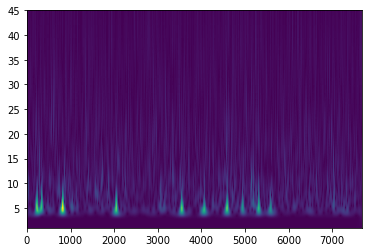

In [ ]:
time_frequency(data)

In [ ]:
feature_scaling(data)

array([[ -5.64024601,  -6.30181644,   0.1281849 , ...,  -1.30083528,
         -2.08828063,   2.64872069],
       [-14.96817089, -15.66596842,   1.55743514, ...,   1.16332515,
          4.28132109,   3.96469104],
       [ -6.46991737,  -3.5058906 ,   1.64927694, ...,  -3.1581315 ,
         -6.13607438, -11.56215392],
       ...,
       [  2.16275617,   0.24080352,   5.38867918, ...,   4.71102998,
          7.84331132,   9.54195591],
       [  5.0348983 ,  12.19782691,  -3.30855304, ..., -28.77932489,
        -28.03502639, -58.93195181],
       [  0.18398614,  -1.26544734,  -3.96146806, ...,  -3.56376222,
         -3.64069077, -10.91627535]])

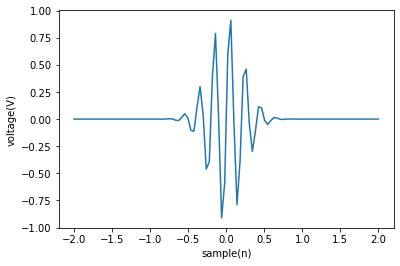

In [ ]:
morlet_wavelet()

SyntaxError: ignored

In [ ]:
# #main.py
# import csv
# import random
# import numpy as np
# import collections
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from keras.utils import to_categorical

# file_path = "/content/drive/My Drive/data_preprocessed_python"
# participant_count = 32
# stimuli_count = 40

# def lstm_power_bands(eeg_data, labels, test_subject=1, sampling_rate=128, part_count=20, ignore_time=0):

#     # Preprocessing
#     preprocessed_eeg = []
#     for item in eeg_data:
#         data = item#preprocessing(item)
#         data = baseline_normalization(data[:, 3*sampling_rate:],
#                                       data[:, 0:3*sampling_rate])

#         preprocessed_eeg.append(data[:, ignore_time*sampling_rate:])

#     # Splitting train and test data based on leave one subject out algorithm
#     splitted_data = group_loso_split([preprocessed_eeg, labels],
#                                      test_subject=test_subject)

#     (data_train, data_test) = splitted_data[0]
#     (labels_train, labels_test) = splitted_data[1]

#     # Balancing train data per participant
#     i = 0
#     balanced_all_data = []
#     balanced_all_labels = []
#     while i < participant_count - 1:
#         start = i * stimuli_count
#         end = (i + 1) * stimuli_count
#         balanced_data, balanced_labels = \
#             balancing_data(data_train[start:end],
#                            labels_train[start:end])
#         balanced_all_data.extend(balanced_data)
#         balanced_all_labels.extend(balanced_labels)
#         i += 1

#     classes = collections.Counter(balanced_all_labels)
#     print(classes)

#     # Shuffling train data (Doing it before segmentation)
#     joint = list(zip(balanced_all_data, balanced_all_labels))
#     random.shuffle(joint)
#     data_train, labels_train = zip(*joint)

#     # segmentation
#     segmented_train_list, segmented_train_labels = \
#         segmentation1(data_train, labels_train, part_count, sampling_rate)
#     segmented_test_list, segmented_test_labels = \
#         segmentation1(data_test, labels_test, part_count, sampling_rate)

#     # Feature extraction
#     train_features = []
#     for item in segmented_train_list:
#         bands = get_total_power_bands(item, sampling_rate)
#         train_features.append(bands)

#     test_features = []
#     for item in segmented_test_list:
#         bands = get_total_power_bands(item, sampling_rate)
#         test_features.append(bands)

#     # Feature scaling
#     scaler = StandardScaler()
#     train_features = scaler.fit_transform(train_features)
#     test_features = scaler.fit_transform(test_features)

#     # Classification
#     train_x = np.reshape(np.array(train_features), (len(train_features), 1, 5))
#     test_x = np.reshape(np.array(test_features), (len(test_features), 1, 5))
#     train_y = np.array(segmented_train_labels)
#     test_y = np.array(segmented_test_labels)

#     print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

#     return segmented_total_power_bands_lstm(train_x, train_y, test_x, test_y)

# def lstm_power_bands_look_back(eeg_data, labels, test_subject=1, sampling_rate=128, part_count=20, ignore_time=0):
#     # Preprocessing
#     preprocessed_eeg = []
#     for item in eeg_data:
#         data = item#preprocessing(item)
#         data = baseline_normalization(data[:, 3*sampling_rate:],
#                                       data[:, 0:3*sampling_rate])

#         preprocessed_eeg.append(data[:, ignore_time*sampling_rate:])


#     # Splitting train and test data based on leave one subject out algorithm
#     splitted_data = group_loso_split([preprocessed_eeg, labels],
#                                      test_subject=test_subject)

#     (data_train, data_test) = splitted_data[0]
#     (labels_train, labels_test) = splitted_data[1]

#     # Balancing train data per participant
#     i = 0
#     balanced_all_data = []
#     balanced_all_labels = []
#     while i < participant_count - 1:
#         start = i * stimuli_count
#         end = (i + 1) * stimuli_count
#         balanced_data, balanced_labels = \
#             balancing_data(data_train[start:end],
#                            labels_train[start:end])
#         balanced_all_data.extend(balanced_data)
#         balanced_all_labels.extend(balanced_labels)
#         i += 1

#     classes = collections.Counter(balanced_all_labels)
#     print(classes)

#     # Shuffling train data (Doing it before segmentation)
#     joint = list(zip(balanced_all_data, balanced_all_labels))
#     random.shuffle(joint)
#     data_train, labels_train = zip(*joint)

#     # segmentation
#     segmented_train_list, segmented_train_labels = \
#         segmentation_for_lstm(data_train, labels_train, part_count, sampling_rate)
#     segmented_test_list, segmented_test_labels = \
#         segmentation_for_lstm(data_test, labels_test, part_count, sampling_rate)

#     # Feature extraction
#     train_features = []
#     for item in segmented_train_list:
#         participant = []
#         for sample in item:
#             bands = get_total_power_bands(sample, sampling_rate)
#             participant.append(bands)
#         train_features.append(participant)

#     test_features = []
#     for item in segmented_test_list:
#         participant = []
#         for sample in item:
#             bands = get_total_power_bands(sample, sampling_rate)
#             participant.append(bands)
#         test_features.append(participant)

#     # Feature scaling
#     train_features = feature_scaling(train_features)
#     test_features = feature_scaling(test_features)

#     # Classification
#     train_x = np.array(train_features)
#     test_x = np.array(test_features)
#     train_y = np.array(segmented_train_labels)
#     test_y = np.array(segmented_test_labels)

#     print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

#     return segmented_total_power_bands_lstm(train_x, train_y, test_x, test_y)

# def lstm_power_bands_look_back_categorical(eeg_data, labels, test_subject=1, sampling_rate=128, part_count=20, ignore_time=0):
#     # Preprocessing
#     preprocessed_eeg = []
#     for item in eeg_data:
#         data = item#preprocessing(item)
#         data = baseline_normalization(data[:, 3*sampling_rate:],
#                                       data[:, 0:3*sampling_rate])

#         preprocessed_eeg.append(data[:, ignore_time*sampling_rate:])


#     # Splitting train and test data based on leave one subject out algorithm
#     splitted_data = group_loso_split([preprocessed_eeg, labels],
#                                      test_subject=test_subject)

#     (data_train, data_test) = splitted_data[0]
#     (labels_train, labels_test) = splitted_data[1]

#     labels_test = to_categorical(np.array(labels_test))

#     # Balancing train data per participant
#     i = 0
#     balanced_all_data = []
#     balanced_all_labels = []
#     while i < participant_count - 1:
#         start = i * stimuli_count
#         end = (i + 1) * stimuli_count
#         balanced_data, balanced_labels = \
#             balancing_data(data_train[start:end],
#                            labels_train[start:end])
#         balanced_all_data.extend(balanced_data)
#         balanced_all_labels.extend(balanced_labels)
#         i += 1

#     classes = collections.Counter(balanced_all_labels)
#     print(classes)

#     # Shuffling train data (Doing it before segmentation)
#     joint = list(zip(balanced_all_data, balanced_all_labels))
#     random.shuffle(joint)
#     data_train, labels_train = zip(*joint)
#     labels_train = to_categorical(np.array(labels_train))

#     # segmentation
#     segmented_train_list, segmented_train_labels = \
#         segmentation_for_lstm(data_train, labels_train, part_count, sampling_rate)
#     segmented_test_list, segmented_test_labels = \
#         segmentation_for_lstm(data_test, labels_test, part_count, sampling_rate)

#     # Feature extraction
#     train_features = []
#     for item in segmented_train_list:
#         participant = []
#         for sample in item:
#             bands = get_total_power_bands(sample, sampling_rate)
#             participant.append(bands)
#         train_features.append(participant)

#     test_features = []
#     for item in segmented_test_list:
#         participant = []
#         for sample in item:
#             bands = get_total_power_bands(sample, sampling_rate)
#             participant.append(bands)
#         test_features.append(participant)

#     # Feature scaling
#     train_features = feature_scaling(train_features)
#     test_features = feature_scaling(test_features)

#     # Classification
#     train_x = np.array(train_features)
#     test_x = np.array(test_features)
#     train_y = np.array(segmented_train_labels)
#     test_y = np.array(segmented_test_labels)

#     print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

#     return segmented_total_power_bands_lstm_categorcal(train_x, train_y, test_x, test_y)

# def lstm_psd_lookback(eeg_data, labels, test_subject=1, sampling_rate=128, part_count=20, ignore_time=0):
#     # Preprocessing
#     preprocessed_eeg = []
#     for item in eeg_data:
#         data = item#preprocessing(item)
#         data = baseline_normalization(data[:, 3*sampling_rate:],
#                                       data[:, 0:3*sampling_rate])

#         preprocessed_eeg.append(data[:, ignore_time*sampling_rate:])

#     # Feature extraction
#     eeg_features = []
#     for item in preprocessed_eeg:
#         eeg_features.append(np.transpose(get_psd(item)))
#     preprocessed_eeg = None
#     # Splitting train and test data based on leave one subject out algorithm
#     splitted_data = group_loso_split([eeg_features, labels],
#                                      test_subject=test_subject)
#     eeg_features = None
#     (data_train, data_test) = splitted_data[0]
#     (labels_train, labels_test) = splitted_data[1]
#     splitted_data = None

#     labels_test = to_categorical(np.array(labels_test))

#     # Balancing train data per participant
#     i = 0
#     balanced_all_data = []
#     balanced_all_labels = []
#     while i < participant_count - 1:
#         start = i * stimuli_count
#         end = (i + 1) * stimuli_count
#         balanced_data, balanced_labels = \
#             balancing_data(data_train[start:end],
#                            labels_train[start:end])
#         balanced_all_data.extend(balanced_data)
#         balanced_all_labels.extend(balanced_labels)
#         i += 1

#     classes = collections.Counter(balanced_all_labels)
#     print(classes)

#     # Shuffling train data (Doing it before segmentation)
#     joint = list(zip(balanced_all_data, balanced_all_labels))
#     random.shuffle(joint)
#     data_train, labels_train = zip(*joint)
#     labels_train = to_categorical(np.array(labels_train))

#     # segmentation
#     segmented_train_list, segmented_train_labels = \
#         segmentation_for_lstm(data_train, labels_train, part_count, sampling_rate)
#     segmented_test_list, segmented_test_labels = \
#         segmentation_for_lstm(data_test, labels_test, part_count, sampling_rate)

#     data_train = None
#     data_test = None
#     labels_train = None
#     labels_test = None
#     # Feature scaling
#     train_features = feature_scaling(segmented_train_list)
#     test_features = feature_scaling(segmented_test_list)
#     segmented_train_list = None
#     segmented_test_list = None
#     # Classification
#     train_x = np.array(train_features)
#     test_x = np.array(test_features)
#     train_y = np.array(segmented_train_labels)
#     test_y = np.array(segmented_test_labels)
#     train_features = None
#     print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

#     return segmented_psd_lstm_categorcal(train_x, train_y, test_x, test_y)

# def svm_power_bands(eeg_data, labels, test_subject=1, sampling_rate=128, part_count=20, ignore_time=0):
#     # Preprocessing
#     preprocessed_eeg = []
#     for item in eeg_data:
#         data = baseline_normalization(item[:, 3*sampling_rate:],
#                                       item[:, 0:3*sampling_rate])

#         preprocessed_eeg.append(data[:, ignore_time*sampling_rate:])

#     # Splitting train and test data based on leave one subject out algorithm
#     splitted_data = group_loso_split([preprocessed_eeg, labels],
#                                      test_subject=test_subject)

#     (data_train, data_test) = splitted_data[0]
#     (labels_train, labels_test) = splitted_data[1]

#     # Balancing train data per participant
#     i = 0
#     balanced_all_data = []
#     balanced_all_labels = []
#     while i < participant_count - 1:
#         start = i * stimuli_count
#         end = (i + 1) * stimuli_count
#         balanced_data, balanced_labels = \
#             balancing_data(data_train[start:end],
#                            labels_train[start:end])
#         balanced_all_data.extend(balanced_data)
#         balanced_all_labels.extend(balanced_labels)
#         i += 1

#     classes = collections.Counter(balanced_all_labels)
#     print(classes)

#     # Shuffling train data (Doing it before segmentation)
#     joint = list(zip(balanced_all_data, balanced_all_labels))
#     random.shuffle(joint)
#     data_train, labels_train = zip(*joint)

#     # segmentation
#     segmented_train_list, segmented_train_labels = \
#         segmentation1(data_train, labels_train, part_count, sampling_rate)
#     segmented_test_list, segmented_test_labels = \
#         segmentation1(data_test, labels_test, part_count, sampling_rate)

#     # Feature extraction
#     train_features = []
#     for item in segmented_train_list:
#         bands = get_total_power_bands(item, sampling_rate)
#         train_features.append(bands)
#     print("TRAIN FEATURES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
#     print(train_features)


#     test_features = []
#     for item in segmented_test_list:
#         bands = get_total_power_bands(item, sampling_rate)
#         test_features.append(bands)
#     print("TEST FEATURES_________________________________________________")
#     print(test_features)

#     # Feature scaling
#     scaler = MinMaxScaler()
#     train_features = scaler.fit_transform(train_features)
#     test_features = scaler.fit_transform(test_features)
#     print(test_features)


#     # Classification
#     train_x = np.array(train_features)
#     test_x = np.array(test_features)
#     train_y = np.array(segmented_train_labels)
#     test_y = np.array(segmented_test_labels)

#     print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

#     return total_power_bands_svm(train_x, train_y, test_x, test_y)

# def test_all_svm_power_bands():
#     # Reading data, preparing labels
#     eeg_data, labels = read_and_prepare_data(file_path)
#     with open("result/svm_power_bands2.csv", 'w') as csv_file:
#         writer = csv.writer(csv_file)
#         row = \
#             ["Subject out",
#              "part count",
#              "accuracy",
#              "precision",
#              "recall",
#              "F_score",
#              "Rmse"]
#         writer.writerow(row)
#         j = 10
#         while j <= 30:
#             i = 0
#             while i < 32:
#                 accuracy, precision, recall, f_score, rmse = \
#                     svm_power_bands(eeg_data, labels, test_subject=i, part_count=j)
#                 row = [i, j, accuracy, precision, recall, f_score, rmse]
#                 writer.writerow(row)
#                 csv_file.flush()
#                 i += 1
#             j += 25

# def test_all_lstm_power_bands_look_back():
#     # Reading data, preparing labels
#     eeg_data, labels = read_and_prepare_data(file_path)
#     with open("result/lstm_power_bands_look_back-2-5.csv", 'w') as csv_file:
#         writer = csv.writer(csv_file)
#         row = \
#             ["Subject out",
#              "part count",
#              "accuracy",
#              "precision",
#              "recall",
#              "F_score",
#              "Rmse"]
#         writer.writerow(row)
#         j = 2
#         while j <= 5:
#             i = 0
#             while i < 32:
#                 accuracy, precision, recall, f_score, rmse = \
#                     lstm_power_bands_look_back(eeg_data, labels, test_subject=i, part_count=j)
#                 row = [i, j, accuracy, precision, recall, f_score, rmse]
#                 writer.writerow(row)
#                 csv_file.flush()
#                 i += 1
#             j += 3

# #test_all_lstm_power_bands_look_back()
# # test_all_svm_power_bands()
# eeg_data, labels = read_and_prepare_data(file_path)
# # lstm_power_bands_look_back(eeg_data, labels, test_subject=0, part_count=10)
# # lstm_power_bands_look_back_categorical(eeg_data, labels, test_subject=0, part_count=10)
# lstm_power_bands(eeg,labels, test_subject=1)
# # lstm_psd_lookback(eeg_data, labels)


# # svm_power_bands(eeg_data,labels, test_subject=1,sampling_rate=128, part_count=20, ignore_time=0)

# def test_other_features(sampling_rate):
#     eeg_data, labels = read_and_prepare_data(file_path)
#     for item in eeg_data:
#         data = baseline_normalization(item[:, 3*sampling_rate:],
#                                       item[:, 0:3*sampling_rate])
#         print(data.shape)
#         # psd = get_psd(data)
#         x = get_power_bands(data)
#         # time_freq = all_channels_time_frequency(data, sampling_rate)
#         # print("psd", psd.shape)
#         # print("time_freq", time_freq.shape)
# # test_other_features(128)